# TP2 : Fouille de données
Loïc Herbelot

## 1) Chargement des données

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bluegills = pd.read_csv('bluegills.txt', delimiter='\t')

## 2) 1ère analyse des données 

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 2 columns):
age       78 non-null int64
length    78 non-null int64
dtypes: int64(2)
memory usage: 1.3 KB

First values:
   age  length
0    1      67
1    1      62
2    2     109
3    2      83
4    2      91


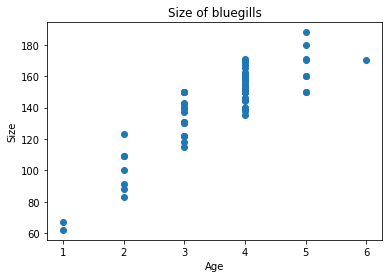

In [10]:
print("Dataframe info:")
bluegills.info()

print("\nFirst values:")
print(bluegills.head())

%matplotlib inline

plt.scatter(bluegills['age'], bluegills['length'])
plt.title("Size of bluegills")
plt.xlabel("Age")
plt.ylabel("Size");

On a a priori un dataset bien formé, pas de données aberrantes ou manquantes.

## 3) Trouver le degré du polynôme

Testing multiple splits
Optimal degree:  2
Optimal degree:  2
Optimal degree:  2
Optimal degree:  2


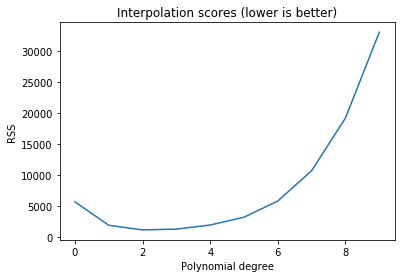

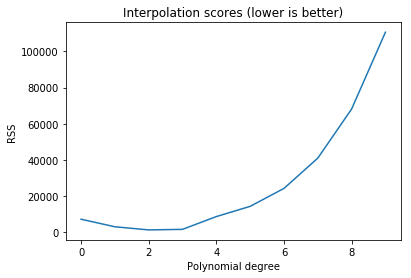

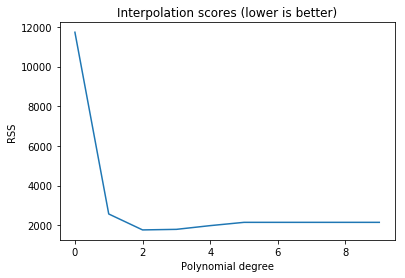

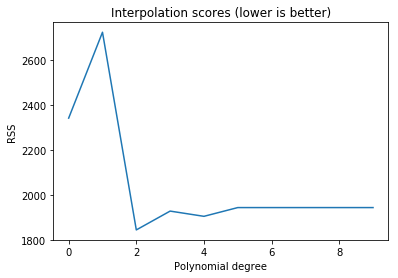

In [11]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Constants:
max_deg = 10
degrees = range(10)
X, Y = bluegills['age'], bluegills['length']


# Ignoring polyfit warnings
import warnings
warnings.simplefilter('ignore', np.RankWarning)

def compute_rss(poly, x_values, y_values):
    """Return the residual sum of squares between the model and the data"""
    rss = 0
    for x,y in zip(x_values, y_values):
        rss += (y - np.polyval(poly, x))**2
    return rss


print("Testing multiple splits")
for split in range(0, 4):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=split)

    scores = []
    for deg in degrees:
        poly = np.polyfit(X_train, Y_train, deg)
        scores.append(compute_rss(poly, X_test, Y_test))
    print("Optimal degree: ", degrees[np.argmin(scores)])
    plt.figure()
    plt.plot(degrees, scores)
    plt.title("Interpolation scores (lower is better)")
    plt.xlabel("Polynomial degree")
    plt.ylabel("RSS")

On voit que les courbes changent drastiquement selon les découpages, ce qui est logique car notre dataset est assez petit. Cependant, la conclusion reste la même : le choix d'un polynôme de 2nd degré est optimal.

## 4) Avec une validation croisée

At the end of the CV, the best degree is 2
Scores of different splits:


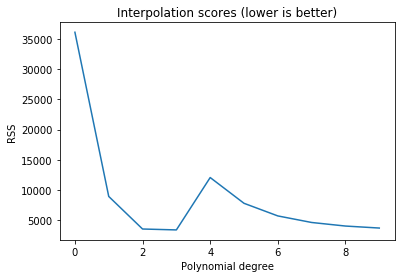

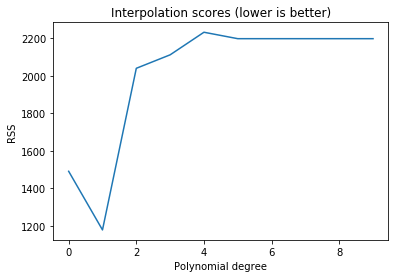

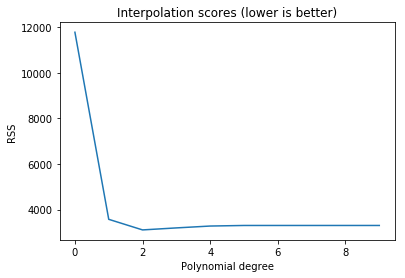

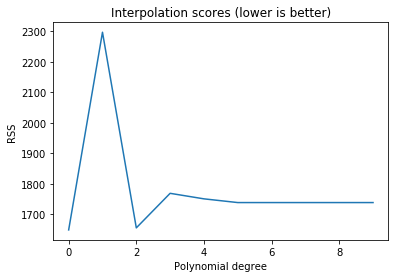

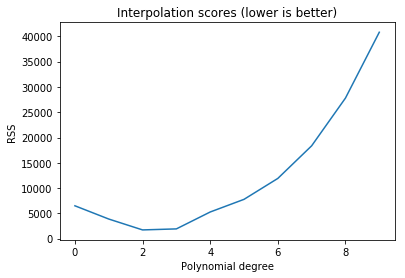

In [12]:
from sklearn.model_selection import KFold

# 5 splits to keep the 80%/20% ration
kf = KFold(n_splits=5, random_state=7)

winners = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    scores = []

    for deg in degrees:
        poly = np.polyfit(X_train, Y_train, deg)
        scores.append(compute_rss(poly, X_test, Y_test))

    best_deg = degrees[np.argmin(scores)]
    winners.append(best_deg)
    
    plt.figure()
    plt.plot(degrees, scores)
    plt.title("Interpolation scores (lower is better)")
    plt.xlabel("Polynomial degree")
    plt.ylabel("RSS")
    
print("At the end of the CV, the best degree is", Counter(winners).most_common(1)[0][0])
print("Scores of different splits:")


Avec une validation croisée k-fold, on obtient un polynôme optimal de degré 2.

## 5) Validation croisée leave-one-out

The degree that won the most splits is 1


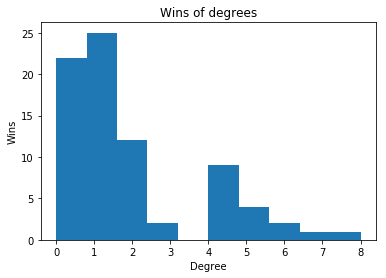

In [13]:
# leave-one-out = n splits 
kf = KFold(n_splits=len(X))


winners = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    scores = []

    for deg in degrees:
        poly = np.polyfit(X_train, Y_train, deg)
        scores.append(compute_rss(poly, X_test, Y_test))

    winners.append(degrees[np.argmin(scores)])
    
plt.hist(winners)
plt.title("Wins of degrees")
plt.xlabel("Degree")
plt.ylabel("Wins");

print("The degree that won the most splits is", Counter(winners).most_common(1)[0][0])

## 6) Akaike information criterion

Soit $y^{(n)}$ le vecteur des longueurs des poissons, on suppose que $y^{(n)}$ suit une loi normale $\mathcal N(\mu^{(k)}(x); \tau)$

avec $\mu^{(k)}(x)= a_0 + a_1 * x + ... + a_k * x^k$ 

Le modèle a comme paramètres $(\tau, a_0, ..., a_k)$, c'est-à-dire $k+2$ paramètres.

On a la formule suivante pour la log-vraisemblance : 

$L(y^n) = \frac n 2 * log(2 \pi * \hat \tau(y^n)) + \frac n 2$

et $\hat \tau (y^n) = \frac 1 n * \sum_{i=1}^n{(y_i - \hat \mu^{(k)}(x_i))^2}$, autrement dit :

$\hat \tau (y^n) = \frac {RSS} n $


Donc $AIC = L(y^n) + (k+2) \\ 
AIC = \frac n 2 * log(2 \pi * \frac {RSS} n) + constante + k $ 

(La constante vaut ici $\frac n 2 + 2$)

Testing multiple splits
Optimal degree: 2
Optimal degree: 2
Optimal degree: 2
Optimal degree: 0


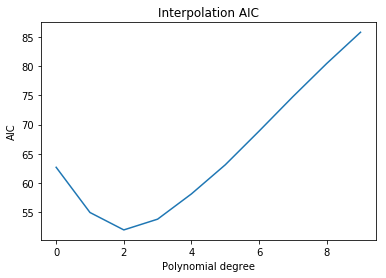

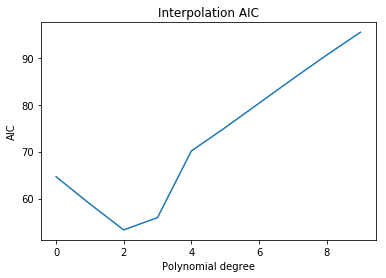

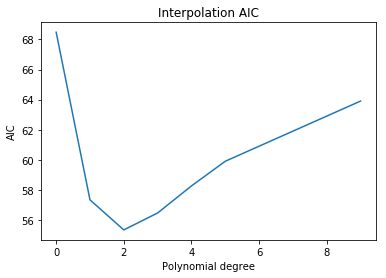

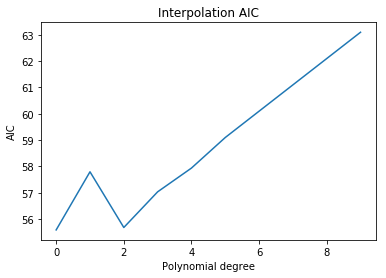

In [14]:
def compute_aic(poly, x_values, y_values):
    """Compute the AIC for a polynomial interpolation"""
    
    n = len(x_values)
    k = len(poly)
    
    aic = k
    rss = compute_rss(poly, x_values, y_values)
    
    aic += n/2. * np.log(2 * np.pi * rss/n)
    
    return aic


print("Testing multiple splits")
for split in range(0, 4):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=split)

    scores = []

    for deg in degrees:
        poly = np.polyfit(X_train, Y_train, deg)
        scores.append(compute_aic(poly, X_test, Y_test))

    print("Optimal degree:", degrees[np.argmin(scores)])
    plt.figure()
    plt.plot(degrees, scores)
    plt.title("Interpolation AIC")
    plt.xlabel("Polynomial degree")
    plt.ylabel("AIC")

On voit que les courbes sont plus stables, l'AIC nous guide vers le choix d'un polynôme de degré 2.

## 7) Bayesian information criterion

$BIC = ln(n) * k - 2 ln(\hat L)$

Testing multiple splits


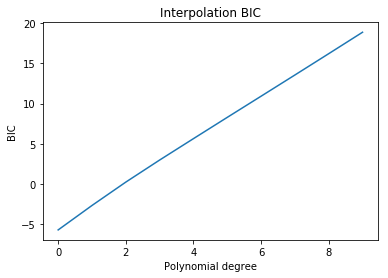

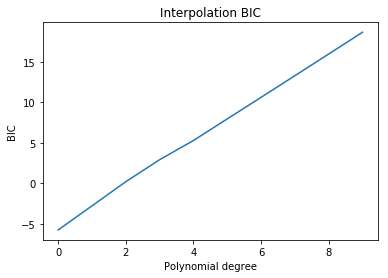

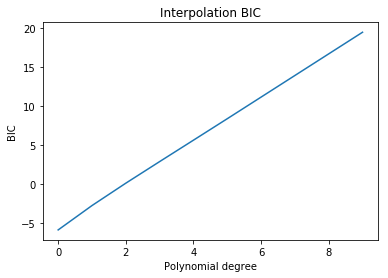

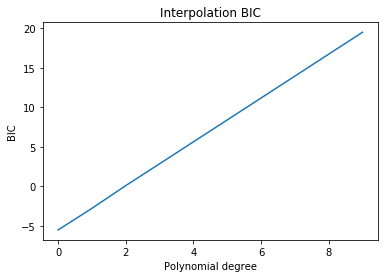

In [15]:
def compute_bic(poly, x_values, y_values):
    """Compute the BIC for a polynomial interpolation"""
    
    n = len(x_values)
    k = len(poly)
    
    bic = np.log(n) * k
    rss = compute_rss(poly, x_values, y_values)
    L = n/2. * np.log(2 * np.pi * rss/n) + n/2.
    
    bic -= 2 * np.log(L)
    
    return bic

print("Testing multiple splits")
for split in range(0, 4):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=split)

    scores = []
    degrees = range(10)

    for deg in degrees:
        poly = np.polyfit(X_train, Y_train, deg)
        scores.append(compute_bic(poly, X_test, Y_test))

    plt.figure()
    plt.plot(degrees, scores)
    plt.title("Interpolation BIC")
    plt.xlabel("Polynomial degree")
    plt.ylabel("BIC")

On voit que le BIC pénalise fortement les modèles complexes, et ainsi le BIC favorise un modèle très simple : une constante.

## 8) Comparaison

D'après les critères de minimisation de l'erreur et la critère AIC, on devrait s'orienter vers un polynôme d'ordre 2, sauf en considérant les résultats de la validation croisée leave-one-out, qui met en avant un polynôme de 1er ordre.

Ainsi en pénalisant ou pas la complexité du modèle, le 2nd ordre apparaît comme optimal.

Cependant, en pénalisant fortement la complexité, avec le BIC, on voit qu'une constante est ce qui pourrait le "mieux" approcher nos données.

On a donc divers résultats qui nous donnent plusieurs conclusions différentes. Dans ce cas on peut choisir la solution qui satisfait le plus de critères.

Je pencherais plutôt vers le choix du degré qui satisfait le plus de critères, c'est-à-dire le 2nd degré.


**Rajoutons des points :**

On va choisir des points au hasard dans nos données, qu'on va dupliquer avec une petite modification qui suit la loi uniforme en ne dépassant pas 1% de la vraie valeur.

Essayons avec un découpage 80%/20%

Testing multiple splits


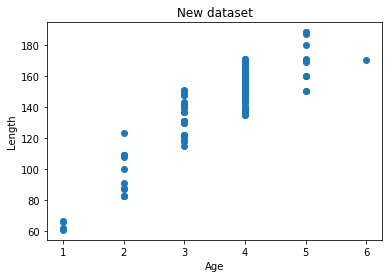

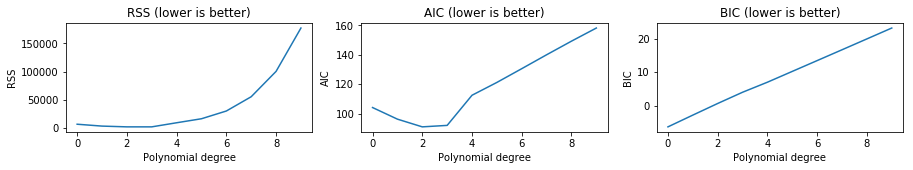

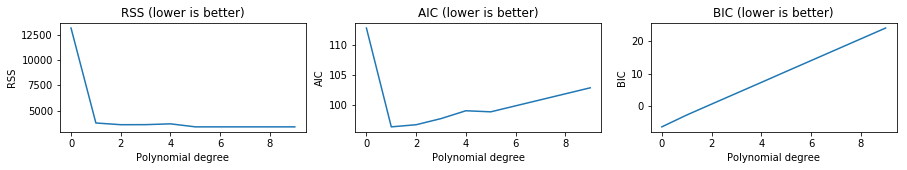

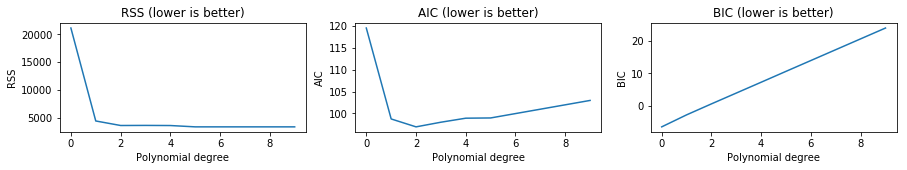

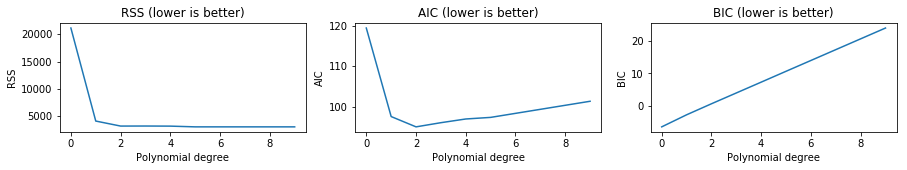

In [18]:
# Add points
X_add, Y_add = X.values, Y.values

# Numbers of points to add:
to_add = 60
n = len(X)

np.random.seed(n)

for i in range(to_add):
    idx = np.random.randint(0, n)
    X_add = np.insert(X_add, -1, X[idx])
    high = Y[idx] / 100.
    err = np.random.rand() * 2 * high - high
#     print("high = %f, err = %f" % (high, err))
    Y_add = np.insert(Y_add, -1 ,Y[idx] + err)
    

plt.scatter(X_add, Y_add)
plt.title("New dataset")
plt.xlabel("Age")
plt.ylabel("Length")

# See the results
print("Testing multiple splits")
for split in range(0, 4):

    X_train, X_test, Y_train, Y_test = train_test_split(X_add, Y_add, test_size=0.2, random_state=split)

    rss_values = []
    aic_values = []
    bic_values = []
    for deg in degrees:
        poly = np.polyfit(X_train, Y_train, deg)
        rss_values.append(compute_rss(poly, X_test, Y_test))
        aic_values.append(compute_aic(poly, X_test, Y_test))
        bic_values.append(compute_bic(poly, X_test, Y_test))
        
    fig = plt.figure(figsize=(15,2))
    fig.add_subplot(131)
    plt.plot(degrees, rss_values)
    plt.title("RSS (lower is better)")
    plt.xlabel("Polynomial degree")
    plt.ylabel("RSS")
    fig.add_subplot(132)
    plt.plot(degrees, aic_values)
    plt.title("AIC (lower is better)")
    plt.xlabel("Polynomial degree")
    plt.ylabel("AIC")
    fig.add_subplot(133)
    plt.plot(degrees, bic_values)
    plt.title("BIC (lower is better)")
    plt.xlabel("Polynomial degree")
    plt.ylabel("BIC")


On voit qu'on a des résultats assez stables lorsqu'on ajoute des points.

**Essayons d'en enlever**

Testing multiple splits


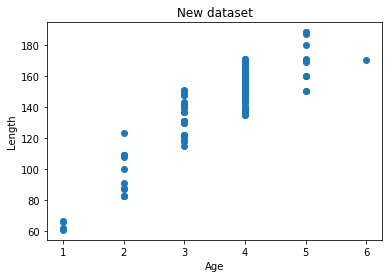

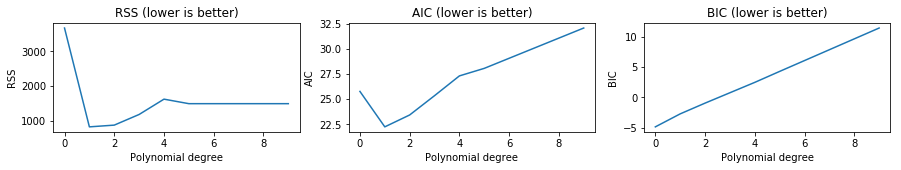

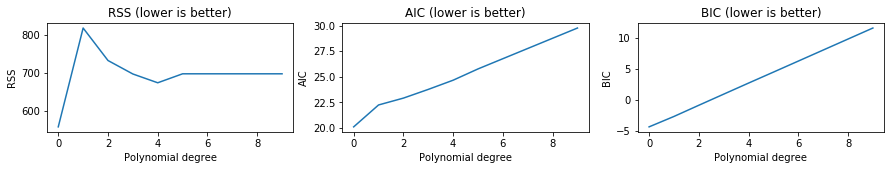

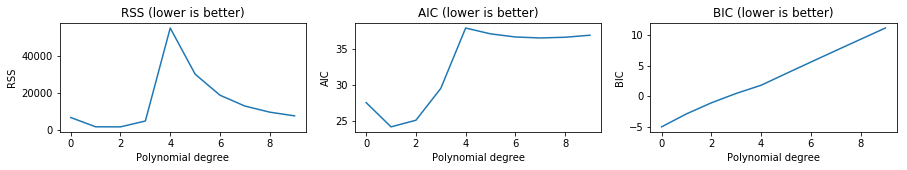

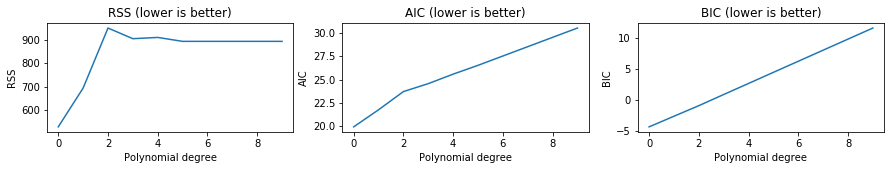

In [21]:
# Remove point
new_n = 30
idx = np.random.choice(range(n), size=new_n)

new_X, new_Y = X[idx], Y[idx]


plt.scatter(X_add, Y_add)
plt.title("New dataset")
plt.xlabel("Age")
plt.ylabel("Length")

# See the results
print("Testing multiple splits")
for split in range(0, 4):

    X_train, X_test, Y_train, Y_test = train_test_split(new_X, new_Y, test_size=0.2, random_state=split)

    rss_values = []
    aic_values = []
    bic_values = []
    for deg in degrees:
        poly = np.polyfit(X_train, Y_train, deg)
        rss_values.append(compute_rss(poly, X_test, Y_test))
        aic_values.append(compute_aic(poly, X_test, Y_test))
        bic_values.append(compute_bic(poly, X_test, Y_test))
        
    fig = plt.figure(figsize=(15,2))
    fig.add_subplot(131)
    plt.plot(degrees, rss_values)
    plt.title("RSS (lower is better)")
    plt.xlabel("Polynomial degree")
    plt.ylabel("RSS")
    fig.add_subplot(132)
    plt.plot(degrees, aic_values)
    plt.title("AIC (lower is better)")
    plt.xlabel("Polynomial degree")
    plt.ylabel("AIC")
    fig.add_subplot(133)
    plt.plot(degrees, bic_values)
    plt.title("BIC (lower is better)")
    plt.xlabel("Polynomial degree")
    plt.ylabel("BIC")

On voit qu'on a des résultats beaucoup plus variables. Ce qui est logique car on est censé utiliser l'AIC et le BIC que lorsque $n$ est grand par rapport au nombre de paramètres (ici on a entre 3 et 5 paramètres)


## 9) Conclusion

D'après les analyses que l'on a effectuées, plusieurs conclusions s'offrent à nous pour le choix du degré :
- Degré 0 : Le meilleur selon le BIC, parfois sélectionné par l'AIC selon le découpage des données mais un peu trop simpliste, on "voit" bien que les données ne sont pas représentées par une constante.
- Degré 1 : Le meilleur selon la LOOCV en suivant le critère MSE. Modèle assez simple, qui impliquerait que la longueur des poissons étudiés soit une fonction linéaire de son âge. Cependant ce modèle ne marche pas bien pour les poissons les plus jeunes et les plus vieux, car à la main on aurait tendance à dessiner une courbe pour essayer de coller aux données. 
- Degré 2 : Le meilleur selon les différens découpages 80%/20%, la validation croisée, pour le MSE et l'AIC. A priori ce modèle respecte le mieux les données. De plus à la main on aurait tendance à dessiner une parabole pour essayer de coller aux données.

Ainsi en comparant les différentes analyses, j'aurais tendance à proposer un polynôme du 2nd degré comme modèle.

## 10) Le vrai modèle 

Le vrai modèle sert de base théorique pour effectuer des calculs, notamment pour trouver des estimateurs, calculer le biais, la variance, valider ou réfuter des hypothèses.